In [23]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import random
import torch
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pylab as plt

import glob
from glob import glob
import nibabel as nb

In [24]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.manual_seed_all(42)

The code will run on GPU.


In [25]:
from dataclasses import dataclass

@dataclass
class Parameters:
    bs : int
    n_channels : int
    ngf : int
    ndf : int
    size : int
    gen_n_down : int
    gen_n_blocks : int
    dis_n_down : int
    lr : float
    beta1 : float

adam_p1= Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=6, dis_n_down=2, lr=0.001, beta1=0.9)
p = adam_p1

In [26]:
#!pip install wandb
import wandb
#!wandb login 2511293b7c38a80081cadf8f2737b2f6fa992e70
wandb.init(project="mri2sos", entity="powerr")



wandb.config={
    'epochs': 2,
    'gen_n_down':p.gen_n_down,
    'gen_n_blocks' : p.gen_n_blocks,
    'dis_n_down' :p.dis_n_down,
    "learning_rate": p.lr,
    "beta1":p.beta1
    }

In [36]:
workers = 2
image_size = (64,64)
dataroot = r'C:\Users\Xiaowei\Desktop\Clara\CycleGAN\Datasets\mri2sos_dataset\train'
datasets_train = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))

from torch.utils import data
idx = [i for i in range(len(datasets_train)) if datasets_train.imgs[i][1] != datasets_train.class_to_idx['B']]
mri_subset = data.Subset(datasets_train, idx)
dataloader_mri = torch.utils.data.DataLoader(mri_subset, batch_size=p.bs,
                                         shuffle=True, num_workers=workers)
idx = [i for i in range(len(datasets_train)) if datasets_train.imgs[i][1] != datasets_train.class_to_idx['A']]
sos_subset = data.Subset(datasets_train, idx)

dataloader_sos = torch.utils.data.DataLoader(sos_subset, batch_size=p.bs,
                                         shuffle=True, num_workers=workers)

In [37]:
def save_models(G_A2B, G_B2A, D_A, D_B, name):

  torch.save(G_A2B, name+"_G_A2B.pt")
  torch.save(G_B2A,  name+"_G_B2A.pt")
  torch.save(D_A,  name+"_D_A.pt")
  torch.save(D_B, name+"_D_B.pt")

def load_models( name):
  G_A2B=torch.load(name+'_G_A2B.pt', map_location=torch.device('cpu'))
  G_B2A=torch.load(name+"_G_B2A.pt",map_location=torch.device('cpu'))
  D_A=torch.load(name+"_D_A.pt", map_location=torch.device('cpu'))
  D_B=torch.load(name+"_D_B.pt", map_location=torch.device('cpu'))
  return G_A2B, G_B2A, D_A, D_B

In [38]:
from ResnetGenerator import ResnetGenerator
from NLayerDiscriminator import NLayerDiscriminator

In [39]:
def LSGAN_D(real, fake):
  return (torch.mean((real - 1)**2) + torch.mean(fake**2))

def LSGAN_G(fake):
  return  torch.mean((fake - 1)**2)

In [40]:
G_A2B = ResnetGenerator(input_nc=p.n_channels,output_nc=p.n_channels,ngf=p.ngf,norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=p.gen_n_blocks, n_downsampling=p.gen_n_down, padding_type='reflect').to(device)
G_B2A = ResnetGenerator(input_nc=p.n_channels,output_nc=p.n_channels,ngf=p.ngf,norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=p.gen_n_blocks, padding_type='reflect').to(device)
D_A = NLayerDiscriminator(input_nc=p.n_channels,ndf=p.ndf,n_layers=p.dis_n_down, norm_layer=nn.BatchNorm2d).to(device)
D_B = NLayerDiscriminator(input_nc=p.n_channels,ndf=p.ndf,n_layers=p.dis_n_down, norm_layer=nn.BatchNorm2d).to(device)
name = "Adam"
save_models(G_A2B, G_B2A, D_A, D_B,name)
# # G_A2B, G_B2A, D_A, D_B= load_models(name)
# # G_A2B.to(device)
# # G_B2A.to(device)
# # D_A.to(device)
# D_B.to(device)

# Initialize Loss function
criterion_Im = torch.nn.L1Loss() 

netG_A2B, netG_B2A, netD_A, netD_B=G_A2B, G_B2A, D_A, D_B

optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(), lr=p.lr, betas=(p.beta1, 0.999))
optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(), lr=p.lr, betas=(p.beta1, 0.999))

optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=p.lr, betas=(p.beta1, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=p.lr, betas=(p.beta1, 0.999))

In [41]:
def plot_images_test(dataloader_mri, dataloader_sos): 
    batch_a_test = next(iter(dataloader_mri))[0][:,0,:,:].unsqueeze(1).to(device)
    real_a_test = batch_a_test.cpu().detach()
    fake_b_test = G_A2B(batch_a_test).cpu().detach()

    plt.subplots(1,4, figsize=(10,80))
    plt.subplot(1,4,1)
    plt.imshow(np.transpose(vutils.make_grid((real_a_test[:4]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real MRIs")
          
    plt.subplot(1,4,2)
    plt.imshow(np.transpose(vutils.make_grid((fake_b_test[:4]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake SoS images")

    batch_b_test = next(iter(dataloader_sos))[0][:,0,:,:].unsqueeze(1).to(device)
    real_b_test = batch_b_test.cpu().detach()
    fake_a_test = G_B2A(batch_b_test ).cpu().detach()
    
    plt.subplot(1,4,3)
    plt.imshow(np.transpose(vutils.make_grid((real_b_test[:4]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real SoS images")

    plt.subplot(1,4,4)
    plt.imshow(np.transpose(vutils.make_grid((fake_a_test[:4]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake MRIs")

def plot_all_images(image_number, dataloader_mri, dataloader_zebra_test): 
    #generate fake zebras
    batch_a_test = next(iter(dataloader_mri))[0][0,0,:,:].unsqueeze(1).to(device)
    real_a_test = batch_a_test.cpu().detach()
    fake_b_test = G_A2B(batch_a_test ).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((real_a_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real MRIs")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_b_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake SoS")
    plt.show()
    #generate fake horses
    batch_b_test = next(iter(dataloader_zebra_test))[0][0,0,:,:].unsqueeze(1).to(device)
    real_b_test = batch_b_test.cpu().detach()
    fake_a_test = G_B2A(batch_b_test ).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((real_b_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real SoS")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_a_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake MRIs")
    plt.show()
    #identity 
    # identity_a_test=G_B2A(batch_a_test.cuda() ).cpu().detach()
    # identity_b_test=G_A2B(batch_b_test.cuda() ).cpu().detach()
    # plt.figure(figsize=(10,10))
    # plt.imshow(np.transpose(vutils.make_grid((identity_a_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    # plt.axis("off")
    # plt.title("Identity MRIs")
    # plt.show()
    # plt.figure(figsize=(10,10))
    # plt.imshow(np.transpose(vutils.make_grid((identity_b_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    # plt.axis("off")
    # plt.title("Identity SoS")
    # plt.show()
    #recovered image
    recover_a_test=G_B2A(fake_b_test.cuda()  ).cpu().detach()
    recover_b_test=G_A2B(fake_a_test.cuda()  ).cpu().detach()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((recover_a_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Recovered MRIs")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((recover_b_test[:image_number]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Recovered SoS")
    plt.show()

In [42]:
def training(G_A2B, G_B2A, D_A, D_B,num_epochs,name,old = True):

  #print(wandb.config)  

  # Training Loop

  # Lists to keep track of progress
  img_list = []
  G_losses = []
  D_A_losses = []
  D_B_losses = []


  iters=0
  FDL_A2B = []
  FDL_B2A = []
  CL_A = []
  CL_B = []
  ID_B2A = []
  ID_A2B = []
  disc_A = []
  disc_B = []


  FDL_A2B_t = []
  FDL_B2A_t = []
  CL_A_t = []
  CL_B_t = []
  ID_B2A_t = []
  ID_A2B_t = []
  disc_A_t = []
  disc_B_t = []

  print("Starting Training Loop...")
  # For each epoch
  for epoch in range(num_epochs):

    # For each batch in the dataloader
    for i,(data_mri, data_sos) in enumerate(zip(dataloader_mri, dataloader_sos),0):
        # print(b)
        # Set model input
        a_real = data_mri[0][:,0,:,:].unsqueeze(1).to(device)
        b_real = data_sos[0][:,0,:,:].unsqueeze(1).to(device)
      
        # tensor_ones=torch.ones([a_real.shape[0],1,14,14]).to(device)
        # tensor_zeros=torch.zeros([a_real.shape[0],1,14,14]).to(device)

        # Generated images
        # print("a_real shape: "+str(a_real.shape))
        b_fake = G_A2B(a_real)
        # print("fake image generated")
        a_rec = G_B2A(b_fake)
        a_fake = G_B2A(b_real)
        b_rec = G_A2B(a_fake)

        # CALCULATE DISCRIMINATORS LOSSES
        # Discriminator A
        optimizer_D_A.zero_grad()
        if((iters > 0 or epoch > 0) and old and iters % 3 == 0):
          rand_int = random.randint(1, old_a_fake.shape[0]-1)
          Disc_loss_A = LSGAN_D(D_A(a_real), D_A(old_a_fake[rand_int-1:rand_int].detach()))
          D_A_losses.append(Disc_loss_A.item())

        else:
          Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
          D_A_losses.append(Disc_loss_A.item())

        # Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
        # D_A_losses.append(Disc_loss_A.item())
        
        Disc_loss_A.backward()
        optimizer_D_A.step()

        
        # Discriminator B

        optimizer_D_B.zero_grad()
        if((iters > 0 or epoch > 0) and old and iters % 3 == 0):
          rand_int = random.randint(1, old_b_fake.shape[0]-1)
          Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(old_b_fake[rand_int-1:rand_int].detach()))
          D_B_losses.append(Disc_loss_B.item())
        else:
          Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(b_fake.detach()))
          D_B_losses.append(Disc_loss_B.item())

        Disc_loss_B.backward()
        optimizer_D_B.step()   

        # Generator

        optimizer_G_A2B.zero_grad()
        optimizer_G_B2A.zero_grad()


        # CALCULATE GENERATORS LOSSES
        Fool_disc_loss_A2B = LSGAN_G(D_B(b_fake))
        Fool_disc_loss_B2A = LSGAN_G(D_A(a_fake))

        # Cycle Consistency    both use the two generators
        Cycle_loss_A = criterion_Im(a_rec, a_real)*5
        Cycle_loss_B = criterion_Im(b_rec, b_real)*5

        # Identity loss
        Id_loss_B2A = criterion_Im(G_B2A(a_real), a_real)*10
        Id_loss_A2B = criterion_Im(G_A2B(b_real), b_real)*10

        # generator losses
        Loss_G = Fool_disc_loss_A2B+Fool_disc_loss_B2A+Cycle_loss_A+Cycle_loss_B+Id_loss_B2A+Id_loss_A2B
        G_losses.append(Loss_G)

        wandb.log({
            "disc_loss_A2B": Fool_disc_loss_A2B,
            "disc_loss_B2A": Fool_disc_loss_B2A,
            "Cycle_loss_A": Cycle_loss_A,
            "Cycle_loss_B": Cycle_loss_B,
            "id_loss_A2B": Id_loss_A2B,
            "id_loss_B2A": Id_loss_B2A,
            "total_g": Loss_G,
            "total_d": Fool_disc_loss_A2B + Fool_disc_loss_B2A
        })

        # Backward propagation
        Loss_G.backward()
        
        # Optimisation step
        optimizer_G_A2B.step()
        optimizer_G_B2A.step()

        FDL_A2B.append(Fool_disc_loss_A2B)
        FDL_B2A.append(Fool_disc_loss_B2A)
        CL_A.append(Cycle_loss_A)
        CL_B.append(Cycle_loss_B)
        ID_B2A.append(Id_loss_B2A)
        ID_A2B.append(Id_loss_A2B)
        disc_A.append(Disc_loss_A)
        disc_B.append(Disc_loss_B)

        if(iters == 0 and epoch == 0):
          old_b_fake = b_fake.clone()
          old_a_fake = a_fake.clone()
        elif (old_b_fake.shape[0] == p.bs*5 and b_fake.shape[0]==p.bs):
          rand_int = random.randint(5, 24)
          old_b_fake[rand_int-5:rand_int] = b_fake.clone()
          old_a_fake[rand_int-5:rand_int] = a_fake.clone()
        elif(old_b_fake.shape[0]< 25):
          old_b_fake = torch.cat((b_fake.clone(),old_b_fake))
          old_a_fake = torch.cat((a_fake.clone(),old_a_fake))

        iters += 1
        del a_real, b_real, a_fake, b_fake


        if iters % 50 == 0:
      
          print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tID_B2A: %.4f\tID_A2B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
                      % (epoch+1, num_epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B,Id_loss_B2A,
                          Id_loss_A2B, Disc_loss_A.item(), Disc_loss_B.item()))
          # print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
          #             % (epoch+1, num_epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B, Disc_loss_A.item(), Disc_loss_B.item()))
        

    FDL_A2B_t.append(sum(FDL_A2B)/len(FDL_A2B))
    FDL_B2A_t.append(sum(FDL_B2A)/len(FDL_B2A))
    CL_A_t.append(sum(CL_A)/len(CL_A))
    CL_B_t.append(sum(CL_B)/len(CL_B))
    ID_B2A_t.append(sum(ID_B2A)/len(ID_B2A))
    ID_A2B_t.append(sum(ID_A2B)/len(ID_A2B))
    disc_A_t.append(sum(disc_A)/len(disc_A))
    disc_B_t.append(sum(disc_B)/len(disc_B))

    FDL_A2B = []
    FDL_B2A = []
    CL_A = []
    CL_B = []
    ID_B2A = []
    ID_A2B = []
    disc_B = []
    disc_A = []

    iters = 0             
    save_models(G_A2B, G_B2A, D_A, D_B, name)
    if (epoch % 5 == 0):
      plot_images_test(dataloader_mri, dataloader_sos)
    # plot_all_images(4, dataloader_vangogh, dataloader_photo)
  return(FDL_A2B_t,FDL_B2A_t,CL_A_t,CL_B_t,ID_B2A_t,ID_A2B_t,disc_A_t,disc_B_t)

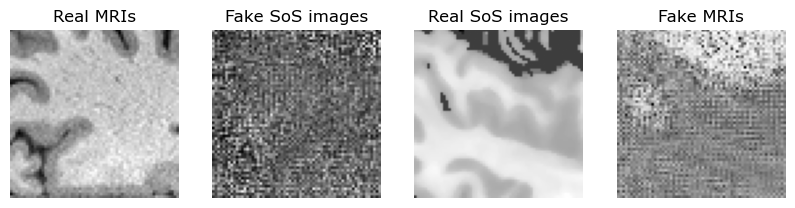

In [43]:
G_A2B, G_B2A, D_A, D_B = load_models(name)
G_A2B.to(device)
G_B2A.to(device)
D_A.to(device)
D_B.to(device)
plot_images_test(dataloader_mri, dataloader_sos)

In [12]:
# import wandb
# wandb.login()
# wandb.init(project="mri2sos-patches", entity="clara_rg_")

Starting Training Loop...
[1/20]	FDL_A2B: 1.5591	FDL_B2A: 1.0117	CL_A: 2.0955	CL_B: 4.6224	ID_B2A: 4.4392	ID_A2B: 9.2339	Loss_D_A: 1.0652	Loss_D_A: 1.5483
[1/20]	FDL_A2B: 1.5364	FDL_B2A: 1.0068	CL_A: 2.1480	CL_B: 4.9066	ID_B2A: 4.5347	ID_A2B: 9.6878	Loss_D_A: 1.0998	Loss_D_A: 1.5816
[1/20]	FDL_A2B: 1.5323	FDL_B2A: 1.0148	CL_A: 2.0927	CL_B: 5.0848	ID_B2A: 4.6523	ID_A2B: 10.0297	Loss_D_A: 1.0797	Loss_D_A: 1.5556
[1/20]	FDL_A2B: 1.5728	FDL_B2A: 1.0154	CL_A: 2.1146	CL_B: 4.2576	ID_B2A: 4.5975	ID_A2B: 8.5608	Loss_D_A: 1.0816	Loss_D_A: 1.6271
[1/20]	FDL_A2B: 1.5251	FDL_B2A: 1.0359	CL_A: 2.1802	CL_B: 4.7252	ID_B2A: 4.7489	ID_A2B: 9.4639	Loss_D_A: 1.0838	Loss_D_A: 1.5887
[1/20]	FDL_A2B: 1.4551	FDL_B2A: 1.0608	CL_A: 2.1004	CL_B: 4.8944	ID_B2A: 4.4550	ID_A2B: 9.7491	Loss_D_A: 1.0717	Loss_D_A: 1.4844
[1/20]	FDL_A2B: 1.5082	FDL_B2A: 1.0739	CL_A: 2.1126	CL_B: 4.7631	ID_B2A: 4.6264	ID_A2B: 9.5209	Loss_D_A: 1.0842	Loss_D_A: 1.5520
[1/20]	FDL_A2B: 1.4901	FDL_B2A: 1.0414	CL_A: 2.3246	CL_B: 5.0618	ID_B2

KeyboardInterrupt: 

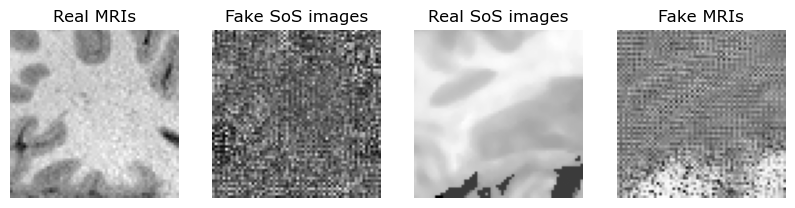

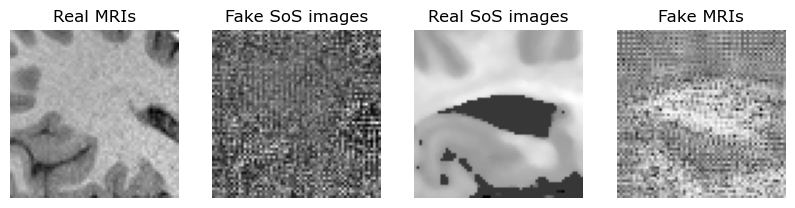

In [44]:
epochs=20
beta1 = 0.8
lr = 0.04
netG_A2B, netG_B2A, netD_A, netD_B=load_models(name)
netG_A2B.to(device)
netG_B2A.to(device)
netD_A.to(device)
netD_B.to(device)

optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(), lr=p.lr, betas=(p.beta1, 0.999))
optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(), lr=p.lr, betas=(p.beta1, 0.999))

optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(p.beta1, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(p.beta1, 0.999))

losses = training( netG_A2B, netG_B2A, netD_A, netD_B,epochs,name)

In [ ]:
G_A2B, G_B2A, D_A, D_B = load_models('try8')
G_A2B_2, G_B2A_2, D_A_2, D_B_2 = load_models('config_3_')

In [ ]:
import os
test_mris = []
test_soss = []
ns = []
count = 0
while count < 50:
    n = random.choice(os.listdir(r'C:\Users\Xiaowei\Desktop\Clara\CycleGAN\Datasets\skull_dataset\train\A')).split('.')[0].split('g')[1]
    if n not in ns:
        ns.append(n)
        test_mris.append(plt.imread(r'C:\Users\Xiaowei\Desktop\Clara\CycleGAN\Datasets\skull_dataset\train\A\mri_img'+str(n)+'.png'))
        test_soss.append(plt.imread(r'C:\Users\Xiaowei\Desktop\Clara\CycleGAN\Datasets\skull_dataset\train\B\sos_img'+str(n)+'.png'))
        count += 1
        print('x', end="")
print('')
print(len(test_mris))

In [ ]:
plt.subplots(1,2)
plt.subplot(1,2,1)
plt.imshow(test_mris[10])
plt.subplot(1,2,2)
plt.imshow(test_soss[10])

In [ ]:
test_fake_mris = []
test_fake_soss = []
test_rec_mris = []
test_rec_soss = []

G_A2B.to(device)
G_B2A.to(device)
D_A.to(device)
D_B.to(device)
for i in range(len(test_mris)):
    real_mri = torch.Tensor(test_mris[i]).unsqueeze(0).unsqueeze(0)
    fake_sos = G_A2B(real_mri.to(device)).cpu().detach().numpy()
    rec_mri = G_B2A(torch.Tensor(fake_sos).to(device)).cpu().detach().numpy()

    real_sos = torch.Tensor(test_soss[i]).unsqueeze(0).unsqueeze(0)
    fake_mri = G_B2A(real_sos.to(device)).cpu().detach().numpy()
    rec_sos = G_A2B(torch.Tensor(fake_mri).to(device)).cpu().detach().numpy()

    test_fake_mris.append(fake_mri)
    test_fake_soss.append(fake_sos)
    test_rec_mris.append(rec_mri)
    test_rec_soss.append(rec_sos)

    with torch.no_grad():
        real_mri.detach().cpu()
        real_sos.detach().cpu()
    # print('After deleting:' + str(torch.cuda.memory_allocated()))

test_fake_mris_2 = []
test_fake_soss_2 = []
test_rec_mris_2 = []
test_rec_soss_2 = []

G_A2B_2.to(device)
G_B2A_2.to(device)
D_A_2.to(device)
D_B_2.to(device)
for i in range(len(test_mris)):
    real_mri = torch.Tensor(test_mris[i]).unsqueeze(0).unsqueeze(0)
    fake_sos = G_A2B_2(real_mri.to(device)).cpu().detach().numpy()
    rec_mri = G_B2A_2(torch.Tensor(fake_sos).to(device)).cpu().detach().numpy()

    real_sos = torch.Tensor(test_soss[i]).unsqueeze(0).unsqueeze(0)
    fake_mri = G_B2A_2(real_sos.to(device)).cpu().detach().numpy()
    rec_sos = G_A2B_2(torch.Tensor(fake_mri).to(device)).cpu().detach().numpy()

    test_fake_mris_2.append(fake_mri)
    test_fake_soss_2.append(fake_sos)
    test_rec_mris_2.append(rec_mri)
    test_rec_soss_2.append(rec_sos)

    with torch.no_grad():
        real_mri.detach().cpu()
        real_sos.detach().cpu()
    # print('After deleting:' + str(torch.cuda.memory_allocated()))

In [ ]:
# n = 10
# plt.subplots(1,2)
# plt.subplot(1,2,1)
# plt.imshow(test_mris[n])
# plt.colorbar()
# plt.clim(0, 1);
# plt.title('Real MRI')
# plt.subplot(1,2,2)
# plt.imshow(test_fake_mris[n][0,0,:,:])
# plt.colorbar()
# plt.clim(0, 1);
# plt.title('Fake MRI')

In [ ]:
plt.subplots(10,2, figsize=(10,40))
count = 0
for i in range(1,21):
    plt.subplot(10,2,i)
    if (i%2):
        plt.imshow(test_mris[count])
        plt.colorbar()
        plt.clim(0, 1);
        plt.title('Real MRI')
    # if(i%3 == 0):
    #     plt.imshow(test_rec_mris[count][0,0,:,:])
    #     plt.colorbar()
    #     plt.title('Reconstructed MRI')
    else:
        #plt.imshow(test_rec_mris[count][0,0,:,:])
        plt.imshow(test_fake_mris[count][0,0,:,:])
        plt.title('Fake MRI')
        plt.colorbar()
        plt.clim(0, 1);
        count += 1

In [ ]:
plt.subplots(9,3, figsize=(10,40))
count = 0
for i in range(1,30):
    plt.subplot(10,3,i)
    if (i in range(1,28,3)):
        plt.imshow(test_mris[count])
        plt.colorbar()
        plt.clim(0, 1);
        plt.title('Real MRI')
    if (i in range(2,29,3)):
        plt.imshow(test_fake_mris[count][0,0,:,:])
        plt.colorbar()
        plt.clim(0,1);
        plt.title('Fake MRI config_4')
    if (i in range(3,30,3)):
        plt.imshow(test_fake_mris_2[count][0,0,:,:])
        plt.title('Fake MRI config_3')
        plt.colorbar()
        plt.clim(0, 1);
        count +=1

In [ ]:
plt.subplots(10,2, figsize=(10,40))
count = 0
for i in range(1,21):
    plt.subplot(10,2,i)
    if (i%2):
        plt.imshow(test_soss[count])
        plt.title('Real SoS')
        plt.colorbar()
        plt.clim(0, 1)
    else:
        plt.imshow(test_rec_soss[count][0,0,:,:])
        plt.imshow(test_fake_soss[count][0,0,:,:])
        plt.title('Reconstructed SoS')
        plt.colorbar()
        plt.clim(0, 1)
        count += 1

# Evaluation

In [ ]:
def average(lst):
    return sum(lst) / len(lst)

1. MSE

In [ ]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err

#https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/

In [ ]:
mri_mses = []
sos_mses = []
for i in range(len(test_mris)):
    # error in fake MRIs
    mri_mses.append(mse(test_mris[i], test_fake_mris[i][0,0,:,:]))

    # error in fake SoS images
    sos_mses.append(mse(test_soss[i], test_fake_soss[i][0,0,:,:]))

In [ ]:
plt.plot([x for x in range(len(test_mris))], mri_mses);
plt.plot([x for x in range(len(test_mris))], sos_mses);
plt.legend(['MSE for MRI generation', 'MSE for SoS generation']);
plt.ylabel('MSE');
plt.xlabel('Images');
print("Average MSE for MRIs: "+str(average(mri_mses)))
print("Average MSE for SoS images: "+str(average(sos_mses)))

2. SSIM

In [ ]:
!pip install scikit-image
from skimage.metrics import structural_similarity as ssim
mri_ssim = []
sos_ssim = []
for i in range(len(test_mris)):
    mri_ssim.append(ssim(test_mris[i], test_fake_mris[i][0,0,:,:]))
    sos_ssim.append(ssim(test_soss[i], test_fake_soss[i][0,0,:,:]))

In [ ]:
plt.plot([x for x in range(len(test_mris))], mri_ssim);
plt.plot([x for x in range(len(test_mris))], sos_ssim);
plt.legend(['SSIM for MRI generation', 'SSIM for SoS generation']);
plt.ylabel('SSIM');
plt.xlabel('Images');
print("Average SSIM for MRIs: "+ str(average(mri_ssim)));
print("Average SSIM for SoS images: "+str(average(sos_ssim)))

3. PSNR

In [ ]:
def PSNR(image1, image2):
    mse = np.mean((image1 - image2) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR has no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [ ]:
mri_psnr = []
sos_psnr = []
for i in range(len(test_mris)):
    mri_psnr.append(PSNR(test_mris[i], test_fake_mris[i][0,0,:,:]))
    sos_psnr.append(PSNR(test_soss[i], test_fake_soss[i][0,0,:,:]))

In [ ]:
plt.plot([x for x in range(len(test_mris))], mri_psnr);
plt.plot([x for x in range(len(test_mris))], sos_psnr);
plt.legend(['PSNR for MRI generation', 'PSNR for SoS generation']);
plt.ylabel('PSNR');
plt.xlabel('Images');
print("Average PSNR for MRIs: "+ str(average(mri_psnr)));
print("Average PSNR for SoS images: "+str(average(sos_psnr)))

4. MAE

In [ ]:
!pip install sklearn
import sklearn.metrics as metrics
mri_mae = []
sos_mae = []
for i in range(len(test_mris)):
    mri_mae.append(metrics.mean_absolute_error(test_mris[i], test_fake_mris[i][0,0,:,:]))
    sos_mae.append(metrics.mean_absolute_error(test_soss[i], test_fake_soss[i][0,0,:,:]))

In [ ]:
plt.plot([x for x in range(len(test_mris))], mri_mae);
plt.plot([x for x in range(len(test_mris))], sos_mae);
plt.legend(['mae for MRI generation', 'mae for SoS generation']);
plt.ylabel('mae');
plt.xlabel('Images');
print("Average mae for MRIs: "+ str(average(mri_mae)));
print("Average mae for SoS images: "+str(average(sos_mae)))

5. Summary

In [ ]:
plt.subplots(1,4, figsize=(20,5))

plt.subplot(1,4,1)
plt.plot([x for x in range(len(test_mris))], mri_mae);
plt.plot([x for x in range(len(test_mris))], sos_mae);
plt.legend(['MRIs', 'SoS images']);
plt.ylabel('MAE', fontsize=15);
plt.xlabel('Images');
txt = "Average MAE, MRIs: "+ str(average(mri_mae))[0:5] + "\nAverage MAE, SoS: "+str(average(sos_mae))[0:5];
plt.figtext(0.22, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12);

plt.subplot(1,4,2)
plt.plot([x for x in range(len(test_mris))], mri_mses);
plt.plot([x for x in range(len(test_mris))], sos_mses);
plt.legend(['MRIs', 'SoS images']);
plt.ylabel('MSE', fontsize=15);
plt.xlabel('Images');
txt = "Average MSE, MRIs: "+str(average(mri_mses))[0:5] + "\nAverage MSE, SoS: "+str(average(sos_mses))[0:5];
plt.figtext(0.41, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12);

plt.subplot(1,4,3)
plt.plot([x for x in range(len(test_mris))], mri_ssim);
plt.plot([x for x in range(len(test_mris))], sos_ssim);
plt.legend(['MRIs', 'SoS images'], loc='upper center');
plt.ylabel('SSIM', fontsize=15);
plt.xlabel('Images');
txt = "Average SSIM, MRIs: "+ str(average(mri_ssim))[0:5] + "\nAverage SSIM, SoS: "+str(average(sos_ssim))[0:5];
plt.figtext(0.61, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12);

plt.subplot(1,4,4)
plt.plot([x for x in range(len(test_mris))], mri_psnr);
plt.plot([x for x in range(len(test_mris))], sos_psnr);
plt.legend(['MRIs', 'SoS images']);
plt.ylabel('PSNR', fontsize=15);
plt.xlabel('Images');
txt = "Average PSNR, MRIs: "+ str(average(mri_psnr))[0:5] + "\nAverage PSNR, SoS: "+str(average(sos_psnr))[0:5];
plt.figtext(0.81, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12);

In [ ]:
np.mean(np.array(test_mris), axis=0).shape

In [ ]:
real_mris = np.mean(np.array(test_mris[:]),axis=0).flatten()
rec_mris = np.mean(np.array(test_rec_mris[:]),axis=0).flatten()
rec_mris = np.mean(np.array(test_fake_mris[:]),axis=0).flatten()
real_soss = np.mean(np.array(test_soss[:]),axis=0).flatten()
rec_soss = np.mean(np.array(test_rec_soss[:]),axis=0).flatten()
fake_soss = np.mean(np.array(test_fake_soss[:]),axis=0).flatten()

plt.subplots(2,2, figsize=(15,15))
plt.subplot(2,2,1)
plt.scatter(real_mris,rec_mris)
plt.xlabel('Original MRI', fontsize=12)
plt.ylabel('Reconstructed MRI', fontsize=12)
plt.subplot(2,2,2)
plt.scatter(real_soss,rec_soss)
plt.xlabel('Original SoS', fontsize=12)
plt.ylabel('Reconstructed SoS', fontsize=12)
plt.subplot(2,2,3)
plt.scatter(real_mris,fake_soss)
plt.xlabel('Original MRIs', fontsize=12)
plt.ylabel('Fake MRIs', fontsize=12)
plt.subplot(2,2,4)
plt.scatter(real_soss,fake_soss)
plt.xlabel('Original SoS', fontsize=12)
plt.ylabel('Fake SoS', fontsize=12)

In [ ]:

plt.subplots(21,2, figsize=(10,80))
plt.title('Reconstructed vs. Original')
count = 0
for n in range(21):
    plt.subplot(21,2,1+count)
    plt.scatter(np.array(test_mris[n]).flatten(), np.array(test_rec_mris[n][0,0,:,:]).flatten())
    plt.xlabel('Original MRI', fontsize=12)
    plt.ylabel('Reconstructed MRI', fontsize=12)
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.subplot(21,2,2+count)
    plt.scatter(np.array(test_soss[n]).flatten(), np.array(test_rec_soss[n][0,0,:,:]).flatten())
    plt.xlabel('Original SoS', fontsize=12)
    plt.ylabel('Reconstructed SoS', fontsize=12)
    plt.ylim(0,1)
    plt.xlim(0,1)
    count+=2

In [ ]:
plt.subplots(21,2, figsize=(10,80))
plt.title('Fake vs. Original')
count = 0
for n in range(21):
    plt.subplot(21,2,1+count)
    plt.scatter(np.array(test_mris[n]).flatten(), np.array(test_fake_mris[n][0,0,:,:]).flatten())
    plt.xlabel('Original MRI', fontsize=12)
    plt.ylabel('Fake MRI', fontsize=12)
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.subplot(21,2,2+count)
    plt.scatter(np.array(test_soss[n]).flatten(), np.array(test_fake_soss[n][0,0,:,:]).flatten())
    plt.xlabel('Original SoS', fontsize=12)
    plt.ylabel('Fake SoS', fontsize=12)
    plt.ylim(0,1)
    plt.xlim(0,1)
    count+=2